In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data = pd.read_csv('Fraud.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6178138 entries, 0 to 6178137
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         float64
 10  isFlaggedFraud  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 518.5+ MB


<Axes: xlabel='type', ylabel='count'>

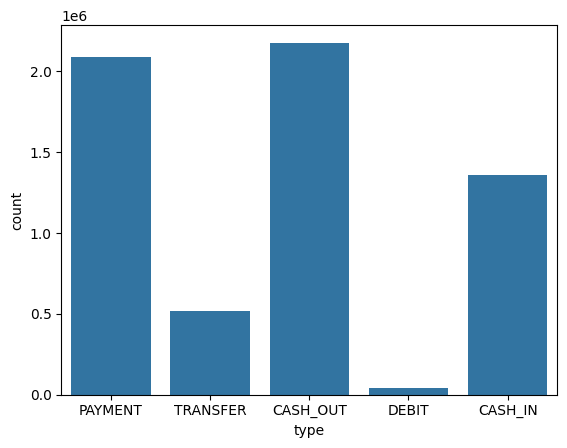

In [3]:
sns.countplot(x='type', data=data)

In [4]:
data['isFraud'].value_counts()

,count
isFraud,
0.0,6171884
1.0,6253


<Axes: >

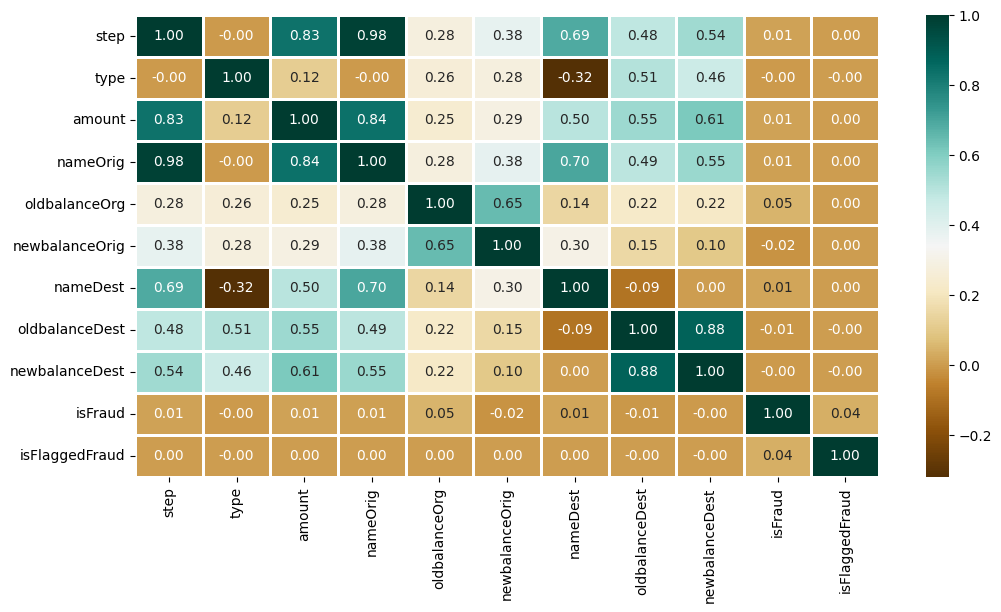

In [5]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.apply(lambda x: pd.factorize(x)[0]).corr(),
			cmap='BrBG',
			fmt='.2f',
			linewidths=2,
			annot=True)

In [2]:
type_new = pd.get_dummies(data['type'], drop_first=True)
data_new = pd.concat([data, type_new], axis=1)
data_new.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0,False,False,True,False
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0,False,False,True,False
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0,False,False,False,True
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0,True,False,False,False
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0,False,False,True,False


In [3]:
X = data_new.drop(['isFraud', 'type', 'nameOrig', 'nameDest'], axis=1)
y = data_new['isFraud']
y

,isFraud
0,0.0
1,0.0
2,1.0
3,1.0
4,0.0
...,...
6178133,0.0
6178134,0.0
6178135,0.0
6178136,0.0


In [8]:
print(y.isna().sum())

1


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [10]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)

In [15]:
from xgboost import XGBClassifier

XGB = XGBClassifier(objective='binary:logistic',
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    scale_pos_weight=10)

In [16]:
from sklearn.model_selection import cross_val_score

y_cleaned = data_new['isFraud'].dropna().astype(int)

X_cleaned = data_new.drop(['isFraud', 'type', 'nameOrig', 'nameDest'], axis=1).loc[y_cleaned.index]



In [ ]:
result = cross_val_score(XGB, X_cleaned, y_cleaned, cv=kfold)
print(f"Cross-validation scores: {result}")

In [17]:
XGB = XGB.fit(X_cleaned, y_cleaned)
XGB


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [18]:
from sklearn.metrics import confusion_matrix

y_pred = XGB.predict(X_cleaned)

confusion = confusion_matrix(y_cleaned, y_pred)
confusion

array([[6170805,    1079],
       [    584,    5669]])

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_cleaned, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6171884
           1       0.84      0.91      0.87      6253

    accuracy                           1.00   6178137
   macro avg       0.92      0.95      0.94   6178137
weighted avg       1.00      1.00      1.00   6178137



In [20]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_cleaned, y_pred)

np.float64(0.953215002310116)